# Import the modules

In [71]:
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
%matplotlib inline

# Import the data

In [86]:
DATA_FOLDER = 'Data/'
# "Handled datasets"
CHARACTER_DATASET = DATA_FOLDER + 'characters.pkl'
MOVIE_DATASET = DATA_FOLDER + 'movies.pkl'

SUMMARIES_DATASET = DATA_FOLDER + 'plot_summaries.txt'
NLP_DATASET = DATA_FOLDER + 'corenlp_plot_summaries.tar'

In [87]:
def load_metadata(path, column_names, header=None, low_memory=False):
    return pd.read_table(path, header=header, names=column_names)

In [88]:
columns_character = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'Actor_gender', 'Actor_height_meters', 'Actor_ethnicity_Freebase_ID', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']
columns_movie = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name','Movie_release_date','Movie_box_office_revenue', 'Movie_runtime','Movie_languages','Movie_countries','Movie_genres' ]

characters = pd.read_pickle(CHARACTER_DATASET)
movies = pd.read_pickle(MOVIE_DATASET)

# Little cleaning

As we pickled our data, we just have to turn the dates back to the pandas datetime format.

We also keep a version of our datasets without dropping the NaN (which are quite numerous, see below).

## Dates as datetime

In [89]:
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='%Y').dt.year
characters.Movie_release_date = pd.to_datetime(characters.Movie_release_date,format='%Y').dt.year
characters.Actor_date_of_birth = pd.to_datetime(characters.Actor_date_of_birth,format='%Y',utc=True,errors='coerce').dt.year

## NaN

In [90]:
print('Number of NaN in the movies dataset:\n',movies.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=movies.isnull().sum().max()/len(movies)*100))
print('\nNumber of NaN in the characters dataset:\n',characters.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=characters.isnull().sum().max()/len(characters)*100))

Number of NaN in the movies dataset:
 Wikipedia_movie_ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64
>>> 89.72% of the rows with at least one NanN

Number of NaN in the characters dataset:
 Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_release_date                   9994
Character_name                     257856
Actor_date_of_birth                106145
Actor_gender                        45603
Actor_height_meters                295825
Actor_ethnicity_Freebase_ID        344589
Actor_name                           1228
Actor_age_at_movie_release         158102
Freebase_character_actor_map_ID         0
Freebase_character_ID              257846
Freebase_actor_ID                     815
dtype: i

In [91]:
characters_nodrop = characters.copy()
movies_nodrop = movies.copy()

characters = characters.dropna()
movies = movies.dropna()

# Visualisations

## Movies

### General statistics

In [92]:
movies_nodrop.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,74839.000000,8.401000e+03,6.129100e+04
mean,1.740784e+07,1977.489892,4.799363e+07,1.118192e+02
std,1.098791e+07,28.886090,1.121753e+08,4.360070e+03
min,3.300000e+02,1888.000000,1.000000e+04,0.000000e+00
25%,7.323695e+06,1956.000000,2.083193e+06,8.100000e+01
50%,1.777899e+07,1985.000000,1.063969e+07,9.300000e+01
75%,2.715573e+07,2004.000000,4.071696e+07,1.060000e+02
max,3.750192e+07,2016.000000,2.782275e+09,1.079281e+06


As expected, the standard variation for the box office revenue is very high. We therefore decide to use the median revenue instead of mean revenue, and plot in y log-scale.

### Some evolutions

#### About the revenue

In [122]:
step = 3 # step for the dates in the x-axis ticks
xmin = int(min(movies.Movie_release_date))
xmax = int(max(movies.Movie_release_date))

Evolution of box office revenue

Text(0.5, 1.0, 'Evolution of median box office revenue per year (log-linear)')

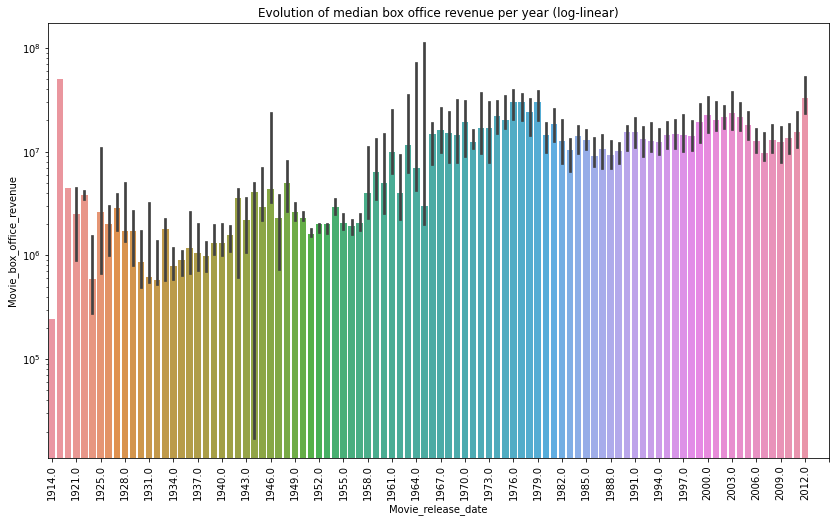

In [124]:
step = 3 # step for the dates in the x-axis ticks
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='Movie_box_office_revenue',estimator='median', ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
#plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of median box office revenue per year (log-linear)')

The high peaks in 1915 seem strange, as for the relative high revenue around 1921. Let us plot the evolution of the number of films per year (only those with a valid revenue i.e non-NaN).

Text(0.5, 1.0, 'Evolution of number of films per year (log-linear)')

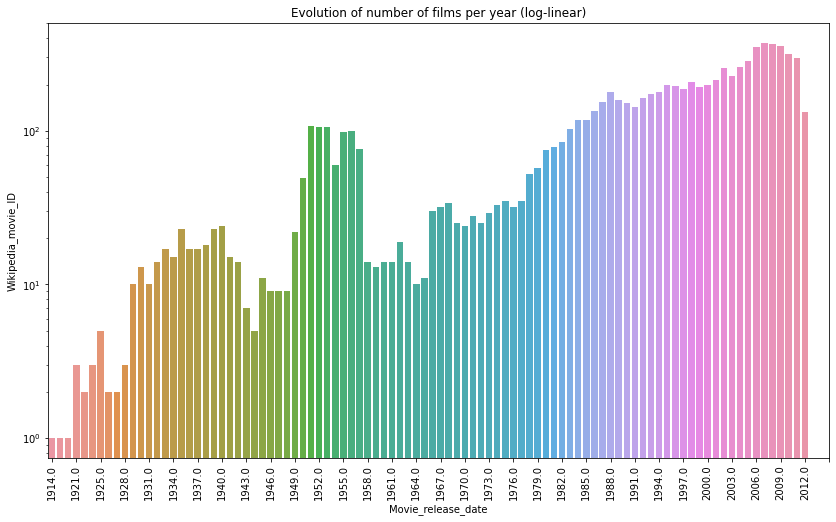

In [127]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='Wikipedia_movie_ID',estimator=len, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
#plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of number of films per year (log-linear)')

Indeed, there was only one film in 1915, and not a lot around 1921. Only the "best films" of the epoch must have been registered in the dataset.

Now let us see the evolution of the median revenue per film.

Text(0.5, 1.0, 'Evolution of median revenue per film (log-linear)')

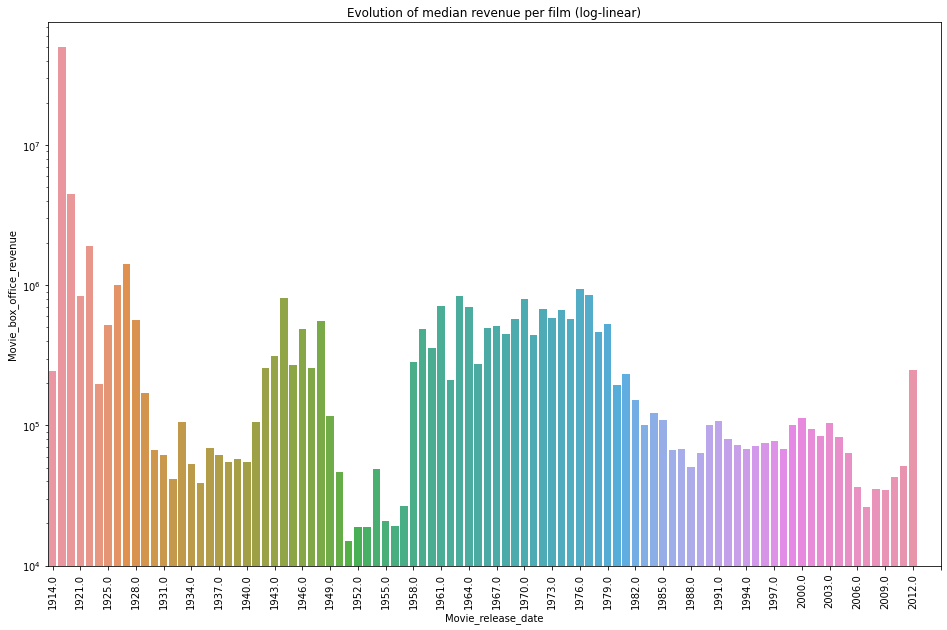

In [131]:
movies_by_year = movies.groupby('Movie_release_date')
movies_by_year_count = movies_by_year.agg('count')
movies_by_year_median = movies_by_year.agg('median',numeric_only=True)
fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(x=movies_by_year_median.index, y=movies_by_year_median.Movie_box_office_revenue/movies_by_year_count.Movie_box_office_revenue, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
plt.yscale('log')
plt.title('Evolution of median revenue per film (log-linear)')

If we do not take in to account the first few years with very little number of films, iIt appears (not conclusive yet, but just an intuition with the plot) that the median revenue per film is "relatively constant" compared to the median revenue. There was a drop around the 50's (missing data or real effect ?), and a little decrease since 1980.

### What about the genres ?